In [1]:
import numpy as np
import pylab as pl
import icgalp_functions as ic
import scipy.io as sio
from matplotlib import rc

In [45]:
#initialize variables

#stop figures from automatically being saved
savefigs = 1

#set seed
np.random.seed(26)

#Set dimension of problem
n = 1024

#Set batchsize for use in variance reduction
batchsize = [32, 256]

#Alternate choice for the matrix A
#A = np.ones(n)
#for i in range(A.shape[0]):
#    if i % 2 == 1:
#        A[i] = -A[i]
#A = np.vstack([A, A])

#Generate random A
A = np.random.uniform(-1, 1, 2 * n).reshape(2, n)

#generate y
y = np.random.uniform(-1, 1, n)
#scale y to be outside of the l1 unit ball
y = 1.5 * (y/np.linalg.norm(y, 1))

In [3]:
#Set the parameters

#gamma is defined to be (log(k+2)^a)/((k+1)^(1-b))
a = 0.0
#b must be < 1 - (1+tau/3)^(-1) where tau is holder exponent
epsi = 0.01
b =  0.25 - epsi
#s is the exponent in the stochastic weight, nu_k = gamma_k ^ s
s = 2./3
#Rho is the augmented lagrangian parameter, taken to be constant
Rho = (2 ** (2-b)) + 1
#delta is the radius of the l1 ball
delta = 1.0
#number of iterations for each method
itera = 10 ** 5

In [4]:
#Use GFB to find x* to high precision
xstar = ic.gfb(y, A, delta, 10 ** 5)

100% (100000 of 100000) |################| Elapsed Time: 0:00:23 Time:  0:00:23


In [5]:
#Check the sparsity of x*
print('The number of nonzero entries in xstar is: '+str(np.count_nonzero(np.absolute(xstar) > 10 ** -8))+' out of '+str(n))

The number of nonzero entries in xstar is: 831 out of 1024


In [6]:
#Run CGALP exactly (i.e. deterministically) as a baseline
#prefix cg
cgx, cgmu, cgerg, cgfeas, cgdist = ic.cgalp(y, A, delta, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


In [9]:
#Sweeping over the components of the gradient of f
#prefix swf
swfx, swfmu, swferg, swffeas, swfdist = ic.icgalp_swf(y, A, delta, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:04 Time:  0:00:04


In [14]:
#Variance reduction with a batch size of 1 on the gradient of f only
#prefix vrf
vrfx, vrfmu, vrferg, vrffeas, vrfdist = ic.icgalp_vrf(y, A, delta, s, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:05 Time:  0:00:05


In [17]:
#Variance reduction with a batch size of 64 on the gradient of f only
#prefix vrfb
vrfbx, vrfbmu, vrfberg, vrfbfeas, vrfbdist = ic.icgalp_vrfb(y, A, batchsize[0], delta, s, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:11 Time:  0:00:11


In [20]:
#Variance reduction with a batch size of 256 on the gradient of f only
#prefix bigb
bigbx, bigbmu, bigberg, bigbfeas, bigbdist = ic.icgalp_vrfb(y, A, batchsize[1], delta, s, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:18 Time:  0:00:18


In [29]:
#Variance reduction with a batch size of 64 on the gradient of f with the quadratic term
#prefix vrfQb
vrfQbx, vrfQbmu, vrfQberg, vrfQbfeas, vrfQbdist = ic.icgalp_vrfQb(y, A, batchsize[0], delta, s, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:10 Time:  0:00:10


In [32]:
#Variance reduction with a batch size of 256 on the gradient of f with the quadratic term
#prefix bvrfQb
bvrfQbx, bvrfQbmu, bvrfQberg, bvrfQbfeas, bvrfQbdist = ic.icgalp_vrfQb(y, A, batchsize[1], delta, s, b, a, Rho, itera, xstar)

100% (99999 of 99999) |##################| Elapsed Time: 0:00:22 Time:  0:00:22


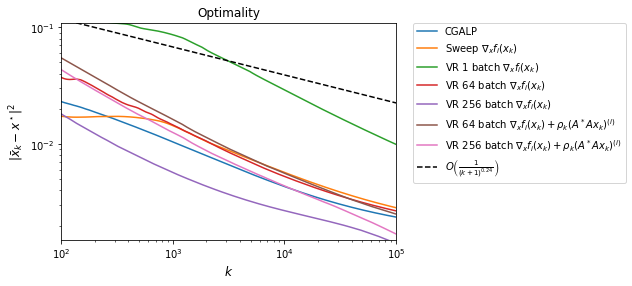

In [46]:
#Plot all optimality results together in loglog scale
pl.plot(cgdist, label='CGALP')
pl.plot(swfdist, label=r'Sweep $\nabla_x f_i(x_k)$')
pl.plot(vrfdist, label=r'VR 1 batch $\nabla_x f_i(x_k)$')
pl.plot(vrfbdist, label=r'VR 64 batch $\nabla_x f_i(x_k)$')
pl.plot(bigbdist, label=r'VR 256 batch $\nabla_x f_i(x_k)$')
pl.plot(vrfQbdist, label=r'VR 64 batch $\nabla_x f_i(x_k) + \rho_k (A^*Ax_k)^{(i)}$')
pl.plot(bvrfQbdist, label=r'VR 256 batch $\nabla_x f_i(x_k) + \rho_k (A^*Ax_k)^{(i)}$')
pl.plot(range(itera), (2 * np.max([cgdist, swfdist, vrfdist, vrfbdist, bigbdist, vrfQbdist, bvrfQbdist]))/((np.array(range(itera)) + 1) ** b), 'k--', label=r'$O\left(\frac{1}{(k+1)^{'+str(b)+r'}}\right)$')
pl.xscale('log')
pl.yscale('log')
pl.xlim(100, 10 ** 5)
pl.ylim(11** -3 * 2, 0.11)
pl.xlabel(r'$k$',fontname="sans-serif", fontsize="12")
pl.ylabel(r'$\|\bar{x}_k-x^\star\|^2$',fontname="serif", fontsize="12")
pl.title('Optimality')
pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
if savefigs == 1:
    pl.savefig(str(n)+'_opt.eps', bbox_inches='tight')
pl.show()

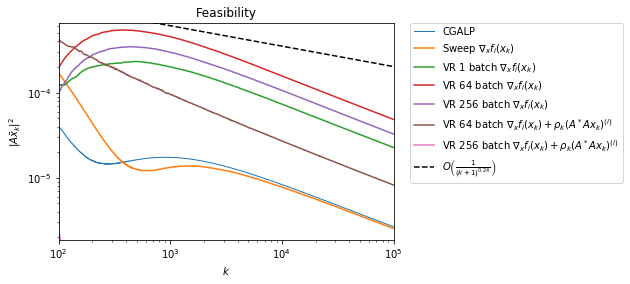

In [47]:
#Plot all feasbility results together in loglog scale
pl.plot(cgfeas, linewidth=1, label='CGALP')
pl.plot(swffeas, label=r'Sweep $\nabla_x f_i(x_k)$')
pl.plot(vrffeas, label=r'VR 1 batch $\nabla_x f_i(x_k)$')
pl.plot(vrfbfeas, label=r'VR 64 batch $\nabla_x f_i(x_k)$')
pl.plot(bigbfeas, label=r'VR 256 batch $\nabla_x f_i(x_k)$')
pl.plot(vrfQbfeas, label=r'VR 64 batch $\nabla_x f_i(x_k) + \rho_k(A^*Ax_k)^{(i)}$')
pl.plot(bvrfQbfeas, label=r'VR 256 batch $\nabla_x f_i(x_k) + \rho_k(A^*Ax_k)^{(i)}$')
pl.plot(range(itera), (0.015 * np.max([cgfeas, swffeas, vrffeas, vrfbfeas, bigbfeas, vrfQbfeas, bvrfQbfeas]))/((np.array(range(itera)) + 1) ** b), 'k--', label=r'$O\left(\frac{1}{(k+1)^{'+str(b)+r'}}\right)$')
pl.xscale('log')
pl.yscale('log')
pl.xlim(100, 10 ** 5)
pl.ylim(14 ** -5, 0.01 /15)
pl.xlabel(r'$k$')
pl.ylabel(r'$\|A\bar{x}_k\|^2$')
pl.title('Feasibility')
pl.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
if savefigs == 1:
    pl.savefig(str(n)+'_feas.eps', bbox_inches='tight')
pl.show()

In [37]:
#These commands save the parameters used for later use in matlab or numpy

#matlab saving
#adict = {}
#adict['n'] = n
#adict['A'] = A
#adict['y'] = y.transpose()
#sio.savemat(str(n)+'_params.mat', adict)

#numpy saving
#np.save(str(n)+'_params', np.array([A, y], dtype=object))